In [1]:
import csv
from torchvision.datasets import MNIST
from torchvision import transforms
from datasets import NUS_WIDE
import torchvision as tv

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np

cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

data_path_train = 'NUS_WIDE_Large/NUS_WIDE_Train'
data_path_test = 'NUS_WIDE_Large/NUS_WIDE_Test'

train_dataset = NUS_WIDE(root=data_path_train,
    transform=transforms.Compose([tv.transforms.Resize((224,224)), transforms.ToTensor(),
                                 transforms.Normalize(mean,std)]), train=True)
test_dataset = NUS_WIDE(root=data_path_test,
    transform=transforms.Compose([tv.transforms.Resize((224,224)), transforms.ToTensor(),
                                 transforms.Normalize(mean,std)]), train=False)


# Obtaining Word Labels

In [2]:
with open('NUS_WIDE_Large/labels.csv') as f:
    reader = csv.reader(f)
    NUS_WIDE_classes = [i[0] for i in list(reader) if i[0] != 'labels.csv']
        
NUS_WIDE_classes[-2] = 'running'
NUS_WIDE_classes[-13] = 'flags'

n_classes = len(NUS_WIDE_classes)

In [3]:
print(NUS_WIDE_classes)
print(n_classes)

['cat', 'cats', 'cave', 'ceremony', 'chairs', 'child', 'church', 'city', 'classroom', 'cliff', 'clouds', 'coast', 'college', 'column', 'commercials', 'computers', 'coral', 'cottage', 'courtyard', 'cows', 'crab', 'crowd', 'crystals', 'dog', 'dogs', 'food', 'fruit', 'goat', 'harbor', 'hawaii', 'hawk', 'helicopter', 'horse', 'hotel', 'ice', 'indian', 'infants', 'insect', 'island', 'jail', 'jeep', 'jet', 'kitchen', 'lake', 'land', 'monks', 'person', 'pottery', 'pyramid', 'rabbit', 'raft', 'reefs', 'referees', 'relief', 'remains', 'reporters', 'rice', 'river', 'road', 'rocks', 'room', 'shops', 'tomb', 'tornado', 'traffic', 'tree', 'trees', 'umbrella', 'underwater', 'flags', 'valley', 'valleys', 'vegetables', 'vegetation', 'vehicle', 'village', 'vines', 'vineyard', 'volcano', 'walking', 'running', 'wall']
82


# Setting up dictionary of word vectors

In [4]:
# Loading Text Vectors
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = torch.FloatTensor(list(map(float, tokens[1:])))
    return data

text_dictionary = load_vectors('wiki-news-300d-1M.vec')

# Text/Image Intermodal Triplet Network Setup

In [8]:
from networks import textEmbedding
from losses import InterTripletLoss
from networks import InterTripletNet
from datasets import IntermodTriplet

i_triplet_train_dataset = IntermodTriplet(train_dataset, NUS_WIDE_classes, text_dictionary) # Returns triplets of images
i_triplet_test_dataset = IntermodTriplet(test_dataset, NUS_WIDE_classes, text_dictionary, train=False)

batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
i_triplet_train_loader = torch.utils.data.DataLoader(i_triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
i_triplet_test_loader = torch.utils.data.DataLoader(i_triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [19]:
batch_idx, (data, target) = next(enumerate(i_triplet_train_loader))

In [29]:
print(len(data))
print(type(data))
print(type(data[0]))
print(data[3])

6
<class 'list'>
<class 'torch.Tensor'>
tensor([[-0.0525,  0.1637, -0.1013,  ...,  0.0649, -0.1802, -0.0553],
        [-0.0069, -0.0469, -0.3206,  ...,  0.0689, -0.0362, -0.1009],
        [ 0.1101,  0.0603,  0.0833,  ...,  0.0829, -0.0412, -0.0495],
        ...,
        [ 0.0431,  0.0361, -0.0245,  ...,  0.0939, -0.1322,  0.0119],
        [-0.0484, -0.0500, -0.2199,  ...,  0.0187,  0.0704, -0.0803],
        [-0.0886,  0.0351,  0.0392,  ..., -0.0215,  0.0461, -0.0554]])


In [5]:
from networks import textEmbedding
from losses import InterTripletLoss
from networks import InterTripletNet
from datasets import IntermodTriplet

i_triplet_train_dataset = IntermodTriplet(train_dataset, NUS_WIDE_classes, text_dictionary) # Returns triplets of images
i_triplet_test_dataset = IntermodTriplet(test_dataset, NUS_WIDE_classes, text_dictionary, train=False)

batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
i_triplet_train_loader = torch.utils.data.DataLoader(i_triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
i_triplet_test_loader = torch.utils.data.DataLoader(i_triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
text_embedding_net = textEmbedding()
image_embedding_net = EmbeddingNet()
model = InterTripletNet(image_embedding_net, text_embedding_net)
if cuda:
    model.cuda()
loss_fn = InterTripletLoss(1.0)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# Fitting Triplet Network

In [6]:
fit(i_triplet_train_loader, i_triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/22996 (0%)]	Loss: 0.101315
Epoch: 1/20. Train set: Average loss: 0.0580
Epoch: 1/20. Validation set: Average loss: 0.0406
Train: [0/22996 (0%)]	Loss: 0.034933
Epoch: 2/20. Train set: Average loss: 0.0341
Epoch: 2/20. Validation set: Average loss: 0.0342
Train: [0/22996 (0%)]	Loss: 0.036829
Epoch: 3/20. Train set: Average loss: 0.0295
Epoch: 3/20. Validation set: Average loss: 0.0323
Train: [0/22996 (0%)]	Loss: 0.029523
Epoch: 4/20. Train set: Average loss: 0.0274
Epoch: 4/20. Validation set: Average loss: 0.0308
Train: [0/22996 (0%)]	Loss: 0.025519
Epoch: 5/20. Train set: Average loss: 0.0247
Epoch: 5/20. Validation set: Average loss: 0.0314
Train: [0/22996 (0%)]	Loss: 0.023570
Epoch: 6/20. Train set: Average loss: 0.0245
Epoch: 6/20. Validation set: Average loss: 0.0299
Train: [0/22996 (0%)]	Loss: 0.023344
Epoch: 7/20. Train set: Average loss: 0.0237
Epoch: 7/20. Validation set: Average loss: 0.0291
Train: [0/22996 (0%)]	Loss: 0.021835
Epoch: 8/20. Train set: Average loss: 0

# K Nearest Neighbors Setup

In [7]:
from datasets import NUS_WIDE_KNN
from sklearn.neighbors import NearestNeighbors
from utils import embedding_indexing_system

test_images = NUS_WIDE_KNN(root=data_path_test,
                          transform=transforms.Compose([tv.transforms.Resize((224,224)), transforms.ToTensor(),
                                                       transforms.Normalize(mean,std)]))
train_images = NUS_WIDE_KNN(root=data_path_train,
                          transform=transforms.Compose([tv.transforms.Resize((224,224)), transforms.ToTensor(),
                                                       transforms.Normalize(mean,std)]))

def k_nearest_neighbors(k, dataloader, model):
    embeddings, idx_to_image = embedding_indexing_system(dataloader, model)
    knn = NearestNeighbors(k)
    knn.fit(embeddings)
    model.eval()
    
    def get_nearest(image):
        nonlocal model
        nonlocal knn
        nonlocal idx_to_image
        
        with torch.no_grad():
            embedded_image = model.get_embedding(image.unsqueeze(0).cuda()).data.cpu().numpy()
            
        k_nearest_indices = knn.kneighbors(X=embedded_image, return_distance=False)
        
        for i in k_nearest_indices[0]:
            plt.figure()
            plt.imshow(idx_to_image[i][0])
    
    def get_nearest_text(word_vector):
        nonlocal model
        nonlocal knn
        nonlocal idx_to_image
        
        with torch.no_grad():
            text_embedding = model.get_embedding_word(word_vector.unsqueeze(0).cuda()).data.cpu().numpy()
            
        k_nearest_indices = knn.kneighbors(X=text_embedding, return_distance=False)
        
        for i in k_nearest_indices[0]:
            plt.figure()
            plt.imshow(idx_to_image[i][0])
    
    return get_nearest, get_nearest_text

In [8]:
get_nearest, get_nearest_text = k_nearest_neighbors(10, train_images, model)

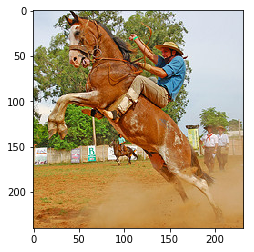

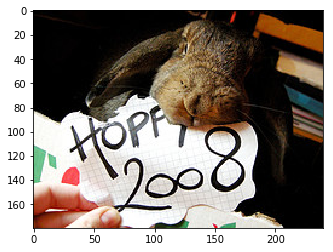

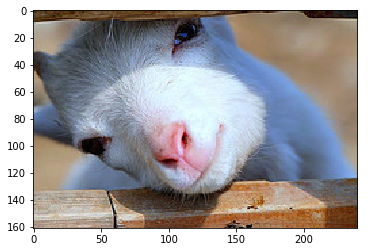

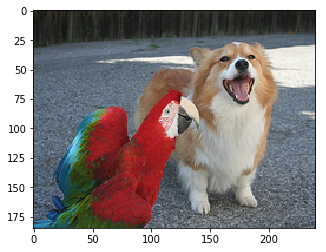

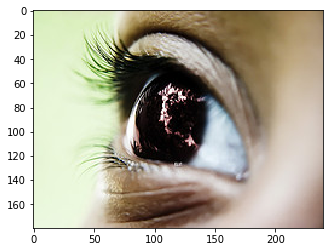

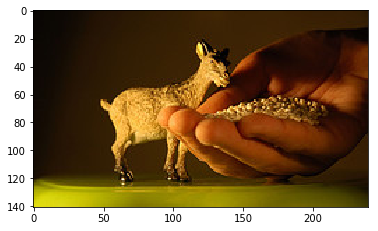

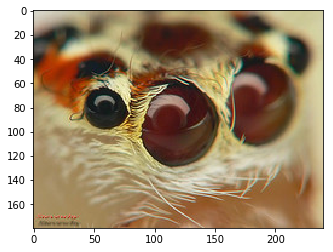

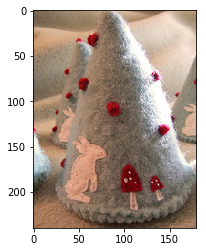

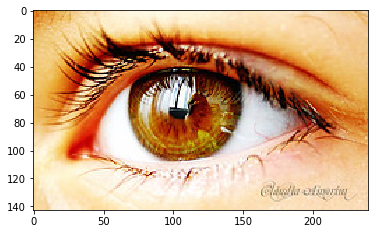

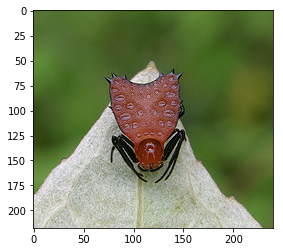

In [40]:
get_nearest_text(text_dictionary['animal'])

In [45]:
import pickle

In [48]:
pickle.dump(text_dictionary, open('word_embeddings_tensors.p', 'wb'))

In [49]:
pickle.dump(model, open('intermodal_82_label_model.p', 'wb'))